In [1]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
import torch

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    # torch_dtype=torch.bfloat16,
)


/mnt/DATA/Conda_Envs/procGen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pipeline.model.model.config

In [3]:
import copy
from transformers import T5ForConditionalGeneration
from transformers import set_seed
import torch.nn as nn
from transformers.models.t5.modeling_t5 import T5LayerSelfAttention  # Import this

set_seed(42)

class CustomFFLayer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the new feedforward layer
        self.additional_ff = nn.Sequential(
            nn.Linear(512, 512*2),  # Input 512, output 512
            nn.Linear(512*2, 512),
            nn.ReLU()
        )

            # Set weights and biases to zero
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.additional_ff:
            if isinstance(layer, nn.Linear):
                nn.init.constant_(layer.weight, 0)  # Set weights to zero
                nn.init.constant_(layer.bias, 0)    # Set biases to zero
        
    def forward(self, x, **kwargs):        
        # Pass through the additional feedforward layer
        x = self.additional_ff(x)
        print(x.shape)
        
        return x

# Define a new layer type for Channel Attention
class ChannelAttentionLayer(T5LayerSelfAttention):
    def __init__(self, config, self_attention_layer, batch_size, num_channels):
        super().__init__(config)

        self.num_channels = num_channels
        self.batch_size = batch_size

        # self.self_attention_layer = self_attention_layer

        # Copy references to the weights from the original attention layer
        self.SelfAttention.q.weight = self_attention_layer.SelfAttention.q.weight
        self.SelfAttention.k.weight = self_attention_layer.SelfAttention.k.weight
        self.SelfAttention.v.weight = self_attention_layer.SelfAttention.v.weight
        self.SelfAttention.o.weight = self_attention_layer.SelfAttention.o.weight

        self.SelfAttention.q.bias = self_attention_layer.SelfAttention.q.bias
        self.SelfAttention.k.bias = self_attention_layer.SelfAttention.k.bias
        self.SelfAttention.v.bias = self_attention_layer.SelfAttention.v.bias
        self.SelfAttention.o.bias = self_attention_layer.SelfAttention.o.bias

        self.layer_norm.weight = self_attention_layer.layer_norm.weight

        self.dropout.p = self_attention_layer.dropout.p
        self.dropout.inplace = self_attention_layer.dropout.inplace

        
        # if hasattr(self_attention_layer.SelfAttention, "relative_attention_bias"):
        #     self.SelfAttention.relative_attention_bias = copy.deepcopy(self_attention_layer.SelfAttention.relative_attention_bias)  # Copy relative_attention_bias if it exists
        #     self.SelfAttention.relative_attention_bias.weight = self_attention_layer.SelfAttention.relative_attention_bias.weight


    def forward(self,hidden_states):
        # input shape [batch_size*num_channels, context_length, dim]
        # print('Hidden state shape input',hidden_states.shape)
        hidden_states = hidden_states.reshape(self.batch_size, self.num_channels, -1, 512)  # [batch_size, num_channels , context_length, dim]
        hidden_states = hidden_states.permute(0, 2, 1, 3)  # [batch_size, context_length, num_channels, dim]
        hidden_states = hidden_states.reshape(-1, self.num_channels, 512)  # [batch_size*context_length, num_channels, dim]
        # print('Hidden state shape after first view',hidden_states.shape)
        output = super().forward(hidden_states)
        hidden_states = output[0] # [batch_size*context_length, num_channels, dim]
        # print('Hidden state shape after super forward',hidden_states.shape)
        hidden_states = hidden_states.reshape(self.batch_size, self.num_channels, -1, 512)  # [batch_size, num_channels, context_length, dim]
        hidden_states = hidden_states.permute(0, 2, 1, 3)  # [batch_size, context_length, num_channels, dim]
        hidden_states = hidden_states.reshape(self.batch_size*self.num_channels, -1, 512)  # [batch_size*num_channels, context_length, dim]
        # print('Hidden state shape after second view',hidden_states.shape)
        output = (hidden_states,) + output[1:]  # Add the rest of the outputs
        return output
    
    # def forward(self,hidden_states):
    #     # input shape [batch_size*num_channels, context_length, dim]
    #     # print('Hidden state shape input',hidden_states.shape)
    #     hidden_states = hidden_states.view(-1, self.num_channels, 512)  # [batch_size*context_length, num_channels, dim]
    #     # print('Hidden state shape after first view',hidden_states.shape)
    #     output = super().forward(hidden_states) # [batch_size*context_length, num_channels, dim]
    #     hidden_states = output[0]
    #     # print('Hidden state shape after super forward',hidden_states.shape)
    #     hidden_states = hidden_states.view(self.batch_size*self.num_channels, -1, 512)  # [batch_size*num_channels, context_length, dim]
    #     # print('Hidden state shape after second view',hidden_states.shape)
    #     output = (hidden_states,) + output[1:]  # Add the rest of the outputs
    #     return output


class CustomT5(T5ForConditionalGeneration):
    def __init__(self, config, batch_size, num_channels):
        super().__init__(config)
        
        # customFF = CustomFFLayer()
        # self.encoder.block[0].layer.insert(1,customFF)

        for i in range(len(self.encoder.block)):
            encoder_block = self.encoder.block[i]
            attention_layer = encoder_block.layer[0]
            
            # Create a channel attention layer with a distinct class
            channel_attention = ChannelAttentionLayer(config, attention_layer, batch_size, num_channels)
            
            # Insert the channel attention layer after the self_attention layer in the list
            encoder_block.layer.insert(1, channel_attention)


In [ ]:
import src.chronos.chronos
import importlib
importlib.reload(src.chronos.chronos)

import torch


context1 = torch.linspace(0, 100, 500).unsqueeze(0).unsqueeze(2)
context2 = (context1.clone()[0,:]*2).unsqueeze(0)
contextTarget = context2+context1
contextNotReshaped = torch.cat((context1, context2, contextTarget), dim=2)

context = contextNotReshaped.reshape(-1, 500, 1).squeeze()

#! Be careful that you are testing with one simple context now.
# for now let stick to the one batch size (1, 512)
# context = torch.linspace(0, 200, 100).unsqueeze(0)

# Number of channels
num_channels = contextNotReshaped.size(-1)

# Number of batches
num_batches = contextNotReshaped.size(0)

print('context shape',context.shape)

token_ids, attention_mask, scale = (
    pipeline.tokenizer.context_input_transform(context)
)

print('token_ids shape',token_ids.shape)
print('attention_mask shape',attention_mask.shape)

context = pipeline._prepare_and_validate_context(context=context)
print('context shape after prepare and validate',context.shape)

print('Number of channels:', num_channels)
print('Number of batches:', num_batches)

context shape torch.Size([3, 500])
token_ids shape torch.Size([3, 501])
attention_mask shape torch.Size([3, 501])
context shape after prepare and validate torch.Size([3, 500])
Number of channels: 3
Number of batches: 1


In [5]:
print(context1.shape)
print(context2.shape)
print(contextTarget.shape)
print(contextNotReshaped.shape)
print(context.shape)

torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 1])
torch.Size([1, 500, 3])
torch.Size([3, 500])


In [6]:
# Load the pre-trained model
original_model = T5ForConditionalGeneration.from_pretrained("amazon/chronos-t5-small")

copy_model = copy.deepcopy(original_model)

# Initialize custom model with the same configuration
custom_model = CustomT5(copy_model.config, num_batches, num_channels)

# Create a new state dictionary for the custom model
custom_state_dict = {}

# Modify the state dictionary from the copied model since the order of layers has changed
for key, value in copy_model.state_dict().items():
    # Rename keys as necessary
    if "encoder.block." in key:
        # Check if the layer index needs adjustment
        if "layer.1.DenseReluDense" in key:  # If it is the layer we added
            new_key = key.replace("layer.1.DenseReluDense", "layer.2.DenseReluDense")  # Shift layer 1 to layer 2
        elif "layer.1.layer_norm" in key:
            new_key = key.replace("layer.1.layer_norm", "layer.2.layer_norm")
        else:
            new_key = key  # No change needed for other layers
    else:
        new_key = key  # No change needed

    custom_state_dict[new_key] = value

# Load the weights from the pre-trained model into the custom model
custom_model.load_state_dict(custom_state_dict, strict=False)  # strict=False allows for architectural changes
# custom_model.load_state_dict(copy_model.state_dict(), strict=False)  # strict=False allows for architectural changes

# Now custom_model should share weights with the original model, except for the new FF layers

_IncompatibleKeys(missing_keys=['encoder.block.0.layer.1.SelfAttention.q.weight', 'encoder.block.0.layer.1.SelfAttention.k.weight', 'encoder.block.0.layer.1.SelfAttention.v.weight', 'encoder.block.0.layer.1.SelfAttention.o.weight', 'encoder.block.0.layer.1.layer_norm.weight', 'encoder.block.1.layer.1.SelfAttention.q.weight', 'encoder.block.1.layer.1.SelfAttention.k.weight', 'encoder.block.1.layer.1.SelfAttention.v.weight', 'encoder.block.1.layer.1.SelfAttention.o.weight', 'encoder.block.1.layer.1.layer_norm.weight', 'encoder.block.2.layer.1.SelfAttention.q.weight', 'encoder.block.2.layer.1.SelfAttention.k.weight', 'encoder.block.2.layer.1.SelfAttention.v.weight', 'encoder.block.2.layer.1.SelfAttention.o.weight', 'encoder.block.2.layer.1.layer_norm.weight', 'encoder.block.3.layer.1.SelfAttention.q.weight', 'encoder.block.3.layer.1.SelfAttention.k.weight', 'encoder.block.3.layer.1.SelfAttention.v.weight', 'encoder.block.3.layer.1.SelfAttention.o.weight', 'encoder.block.3.layer.1.layer_no

In [7]:
predictions_from_original_model = []
remaining = 50

while remaining > 0:
    token_ids, attention_mask, scale = pipeline.tokenizer.context_input_transform(
        context
    )
    samples = original_model.generate(
                input_ids=token_ids,
                attention_mask=attention_mask, 
                min_new_tokens=50,
                max_new_tokens=50,
                do_sample=True,
                # num_samples= 1,
                num_return_sequences=1,
                eos_token_id=pipeline.model.config.eos_token_id,
                pad_token_id=pipeline.model.config.pad_token_id)
    

    samples = samples[..., 1:]
    samples = samples.reshape(token_ids.size(0), 1, -1)
    
    prediction = pipeline.tokenizer.output_transform(
        samples.to(scale.device), scale
    )

    predictions_from_original_model.append(prediction)
    remaining -= prediction.shape[-1]

    if remaining <= 0:
        break

    context = torch.cat(
        [context, prediction.median(dim=1).values], dim=-1
    )


data_original_to_plot = torch.concat((context,predictions_from_original_model[0][:,0,:]),dim=1)


import matplotlib.pyplot as plt
import numpy as np
data_original_to_plot = np.array(data_original_to_plot)
for i in range(data_original_to_plot.shape[0]):
    plt.plot(data_original_to_plot[i,:])
plt.title("Original Model")
plt.grid()

RuntimeError: The size of tensor a (501) must match the size of tensor b (3) at non-singleton dimension 0

torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
Prediction shape: torch.Size([1, 1, 3, 50])


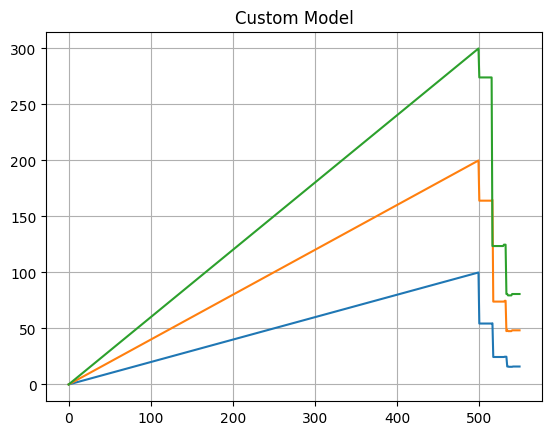

In [15]:
predictions_from_custom_model = []
remaining = 50
num_samples = 1

while remaining > 0:
    token_ids, attention_mask, scale = pipeline.tokenizer.context_input_transform(
        context
    )
    samples = custom_model.generate(
                input_ids=token_ids,
                attention_mask=attention_mask, 
                min_new_tokens=50,
                max_new_tokens=50,
                do_sample=True,
                num_return_sequences=num_samples,
                eos_token_id=pipeline.model.config.eos_token_id,
                pad_token_id=pipeline.model.config.pad_token_id)
    
    samples = samples[..., 1:]
    samples = samples.reshape(num_batches, num_samples, -1, num_channels)
    # samples = samples.reshape(token_ids.size(0), num_samples, -1)

    # prediction = pipeline.tokenizer.output_transform(
    #     samples.to(scale.device), scale
    # )
    temp = []
    for i in range(num_channels):
        prediction = pipeline.tokenizer.output_transform(
            samples[:,:,:,i].to(scale.device), scale[i].unsqueeze(0)
        )
        print(samples[:,:,:,i].shape)
        print(prediction.shape)
        temp.append(prediction)

    prediction = torch.stack(temp, dim=-1)

    prediction = prediction.reshape(num_batches, num_samples, num_channels, -1)
    print('Prediction shape:',prediction.shape)


    remaining -= prediction.shape[-1]

    prediction = prediction.reshape(num_batches, num_samples, -1, num_channels)
    

    predictions_from_custom_model.append(prediction)

    predictions_from_custom_model = torch.cat(predictions_from_custom_model, dim=-1)


    if remaining <= 0:
        break

    context = torch.cat(
        [context, prediction.median(dim=1).values], dim=-1
    )


context2 = context.reshape(num_batches, -1, num_channels)

data_custom_to_plot = torch.concat((context2[0,:,:],predictions_from_custom_model[0,0,:,:]),dim=0)


import matplotlib.pyplot as plt
import numpy as np
data_custom_to_plot = np.array(data_custom_to_plot)
plt.plot(data_custom_to_plot)
# for i in range(data_custom_to_plot.shape[0]):
#     plt.plot(data_custom_to_plot[i,:])
plt.title("Custom Model")
plt.grid()

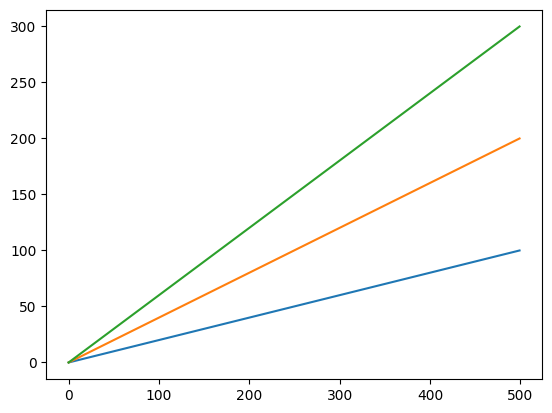

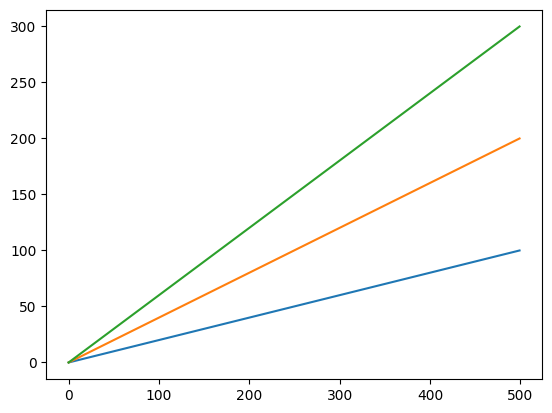

torch.Size([3, 500])


torch.Size([500, 3])

In [11]:
context3 = context.reshape(num_channels, -1,num_batches )
context3.shape
plt.plot(context3[:,:,0].reshape(-1,3))
plt.show()
plt.plot(context2[0,:,:])
plt.show()
print(context3[:,:,0].shape)
context2[0,:,:].shape

In [9]:
forecast = pipeline.predict(context=torch.linspace(1,100,500).unsqueeze(0), prediction_length=50, num_samples=2)

In [14]:
# forecast.size()

In [15]:
# print('Difference between forecast from the api and manual:')
# forecast - predictions_from_original_model[0]